$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\renewcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\grad}[0]{\nabla}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\Var}[1]{\mathrm{Var}\left[#1\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[0]{\middle\vert}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\trace}{trace}
\newcommand{\1}[1]{\mathbb{I}\left\{#1\right\}}
\newcommand{\setof}[1]{\left\{#1\right\}}
\newcommand{\DO}[1]{\mathrm{do}\left(#1\right)}
\newcommand{\indep}{\perp \!\!\! \perp}
$$


# <center>Causal Inference 097400, Winter 2019-20<br><br>Homework 3</center>

#### <center>Aviv Rosenberg<br>`avivr@cs`</center>

##### <center>January 5, 2020<br></center>


The code implementing the assignment is in the `hw3` package right next to this notebook.

The structure of this project is:
```
+
|- data/                # Folder for raw data files
|- out/                 # Output folder where result CSVs are saved
|- hw3/
|---- data.py           # Data loading and preprocessing
|---- propensity.py     # Propensity score estimation
|---- att.py            # Calculation of ATT
|---- cv.py             # Cross-validation for fitting various models
|- hw3.ipynb            # Notebook that runs the code and displays results
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd

DATA_FILE1 = 'data/data1.csv'
DATA_FILE2 = 'data/data2.csv'
OUT_DIR = 'out/'

os.makedirs(OUT_DIR, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
plt.rcParams['font.size'] = 12

## Part 1: Loading the data

Here we're just loading the raw CSV files.

In [3]:
from hw3.data import load_data, encode_categorical, get_training_data
    
df1 = load_data(DATA_FILE1)
df2 = load_data(DATA_FILE2)

df1.tail(5)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,T,Y
4797,21,C,0.0,0.0,67,140,0,0,2,0,...,0,0,0,0,0,1,47,39,0,-1.452833
4798,24,E,0.0,0.0,62,130,0,0,0,0,...,0,0,0,0,0,1,46,40,0,-10.182280
4799,33,C,5.0,15.0,63,137,0,0,0,0,...,0,0,0,0,0,0,46,38,0,0.441606
4800,36,C,10.0,22.0,60,110,0,0,1,0,...,0,0,0,0,0,0,46,38,0,-1.336014
4801,18,C,0.0,0.0,65,110,0,0,0,0,...,0,0,0,0,0,0,45,37,0,8.828653


 Some variables in the dataset (e.g. `x_2`) are given as categorical values, so we encode these as sequential integers.

In [4]:
df1 = encode_categorical(df1)
df2 = encode_categorical(df2)

dataframes = (df1, df2)
dataset_names = ('data1', 'data2')

df1.tail(5)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,T,Y
4797,21,2.0,0.0,0.0,67,140,0,0,2,0,...,0,0,0,0,0,1,47,39,0,-1.452833
4798,24,4.0,0.0,0.0,62,130,0,0,0,0,...,0,0,0,0,0,1,46,40,0,-10.182280
4799,33,2.0,5.0,15.0,63,137,0,0,0,0,...,0,0,0,0,0,0,46,38,0,0.441606
4800,36,2.0,10.0,22.0,60,110,0,0,1,0,...,0,0,0,0,0,0,46,38,0,-1.336014
4801,18,2.0,0.0,0.0,65,110,0,0,0,0,...,0,0,0,0,0,0,45,37,0,8.828653


Let's take a look at the outcome distribution among the treatment and control groups.

In [5]:
for i, df in enumerate(dataframes):
    groups = df.groupby('T')
    print(f'{dataset_names[i]} outcome:')
    display(groups['Y'].agg(['mean','std','median','count']))

data1 outcome:


,mean,std,median,count
T,,,,
0,8.251061,5.548459,8.357503,1529
1,13.667329,5.827545,15.069250,3273


data2 outcome:


,mean,std,median,count
T,,,,
0,-0.512850,4.056643,-0.833142,2176
1,3.389848,6.422401,1.585648,2626


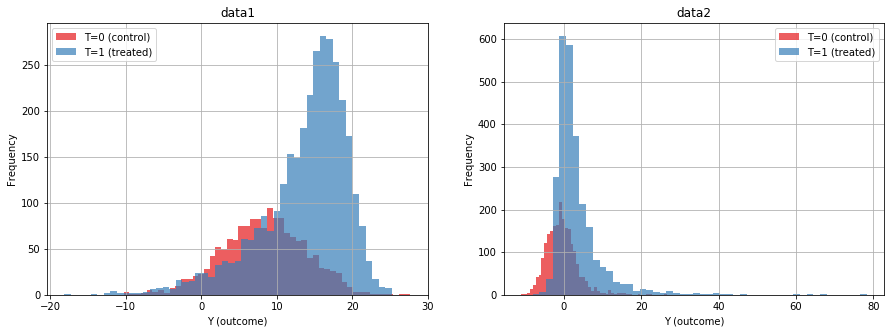

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(15, 5))
for i, df in enumerate(dataframes):
    groups = df.groupby('T')
    groups['Y'].plot(kind='hist', ax=ax[i], sharex=True, alpha=0.7, bins=50)
    ax[i].set_title(f'{dataset_names[i]}')
    ax[i].set_xlabel('Y (outcome)')
    ax[i].grid(True)
    ax[i].legend([f'T=0 (control)','T=1 (treated)'])

In both datasets we can see a better outcome on average for the treated, but of course this does not prove a causal effect.

# Part 2: Propensity Estimation

The *propensity score* is defined as $e(\vec{x}):=\Pr{\left(\rvar{T}=1\given \rvec{X}=\vec{x}\right)}$.
In other words, it is the probability that a treatment $\rvar{T}=1$ will be assigned to a
unit with covariates $\rvec{X}=\vec{x}$.
We would like to obtain an estimator for the propensity score, $\hat e(\vec{x})$, from the data.
One important aspect of this estimator is that we would like it to be *calibrated*.
Briefly, this means that for if for example we look at all units $\vec{x}$ such that $e(\vec{x})=0.8$, we expect 80\% of them to actually belong to the treatment group ($\rvar{T}=1$).

To estimate the propensities, we first fit a classification model to predict $\rvar{T}$ from $\rvec{X}$.
We tried three common classification models: logistic regression (`logistic`), gradient boosting machines (`gbm`), and naive Bayes (`nb`).
Then, for each fitted model we applied a calibration method to obtain a new model with better-calibrated probability outputs. The calibration is performed on a disjoint validation set which includes 30\% of the data chosen at random but with stratification on $\rvar{T}$. The propensity scores from the model with the lowest Brier score after calibration are used.

The propensity model is fitted in the `fit_propensity_cv` function within the `propensity.py` module.
This function first performs Cross Validation to find parameters for a classifier, and then runs the calibration methods to calibrate the classifier's output.

In [7]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from scipy import stats

from hw3.cv import CVConfig, LogSpaceSampler

# Define the methods and CV search space for propensity estimation
rcv_config = {
    'logistic': CVConfig(
        model=LogisticRegression(dual=False, solver='liblinear'),
        params=dict(C=LogSpaceSampler(-5, 2), penalty=['l1','l2']),
    ),
    'gbm': CVConfig(
        model=GradientBoostingClassifier(),
        params=dict(
            n_estimators=stats.randint(10, 100 + 1),
            max_depth=stats.randint(1, 3 + 1),
            learning_rate=LogSpaceSampler(-2, 0.5),
        )
    ),
    'nb': CVConfig(
        model=GaussianNB(),
        params=dict(var_smoothing=LogSpaceSampler(-11, -6),)
    ),
}

data1 logistic 	best_params={'model__C': 0.015577217702693023, 'model__penalty': 'l1'}
data2 logistic 	best_params={'model__C': 0.11645030315885957, 'model__penalty': 'l1'}
data1 gbm 	best_params={'model__learning_rate': 0.060155825411672505, 'model__max_depth': 2, 'model__n_estimators': 63}
data2 gbm 	best_params={'model__learning_rate': 0.20987186846453523, 'model__max_depth': 2, 'model__n_estimators': 13}
data1 nb 	best_params={'model__var_smoothing': 7.45934328572655e-10}
data2 nb 	best_params={'model__var_smoothing': 3.7607358658275915e-11}


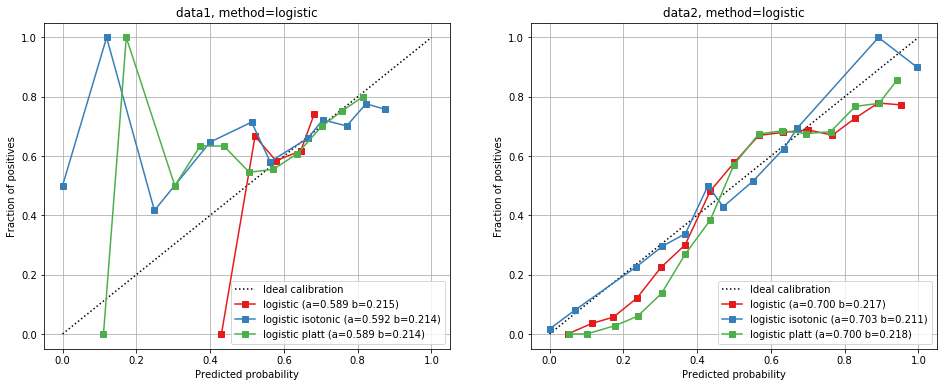

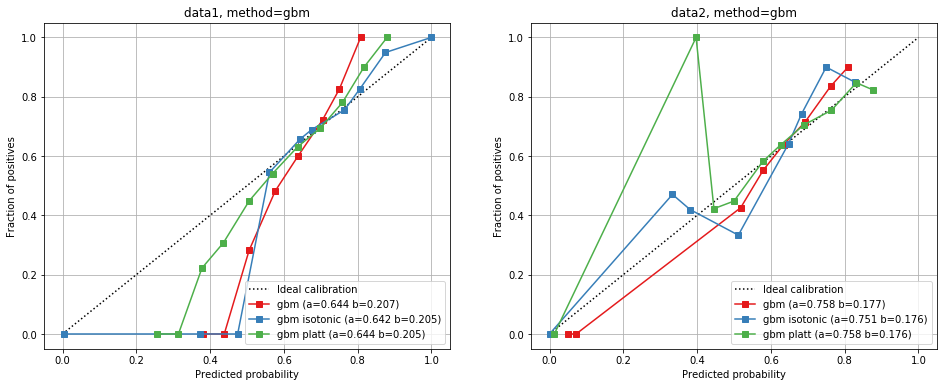

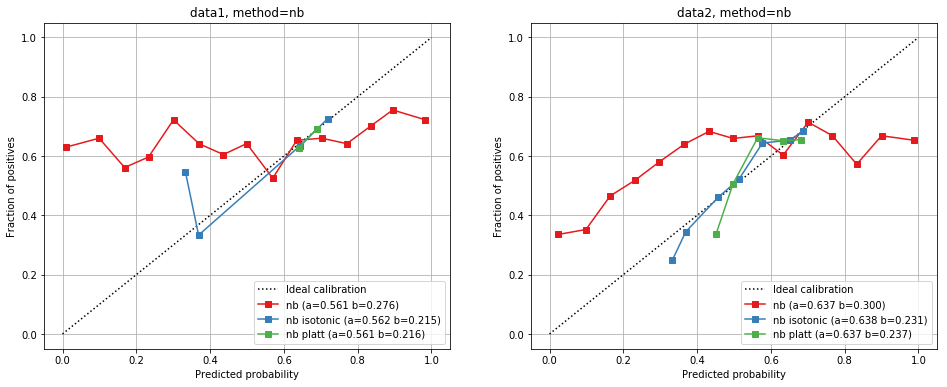

In [8]:
from hw3.propensity import fit_propensity_cv

# Create a dataframe to store propensities from each dataset and each method
midx = pd.MultiIndex.from_product([dataset_names, rcv_config.keys()], names=['dataset', 'method'])
df_propensity = pd.DataFrame(columns=midx)

for method, cv_cfg in rcv_config.items():
    fig, ax = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(16, 6))
    
    for i, df in enumerate(dataframes):
        # Get covariates X and treatment assignment t as numpy arrays
        X, _, t, _ = get_training_data(df, scale_covariates=True, col_prop=None)
        
        # Train a model to estimate propensity using current method,
        # calibrate with two approaches and generate a calibration plot
        model, best_params = fit_propensity_cv(
            cv_cfg, X, t, plot_args=dict(name=method, ax=ax[i]),
            test_size=0.3, n_iter=42, random_state=42+i, cv_splits=4
        )
        
        # Use the best calibrated model (lowest Brier score) to estimate the propensities
        prop = model.predict_proba(X)[:, 1]
        df_propensity[(dataset_names[i], method)] = prop
        
        ax[i].set_title(f'{dataset_names[i]}, method={method}')
        print(f'{dataset_names[i]} {method} \tbest_params={best_params}')

The plots above show the calibration curves of the logistic regression (top row), the GBM models (middle row) and the NB models (bottom row).
The ideal calibration is shown as a dotted line.
For each classifier, two calibration methods, Platt and Isotonic Regression, are shown.
In the legend, both the ROC-AUC score (`a`) and the Brier score (`b`) are reported as measures of the model's
classification performance (higher is better) and de-calibration level (lower is better), respectively.

We now have all the propensity scores from each method:

In [9]:
df_propensity.head()

dataset     data1                         data2                    
method   logistic       gbm        nb  logistic       gbm        nb
0        0.638465  0.593160  0.601738  0.782983  0.803678  0.802938
1        0.640562  0.575196  0.618998  0.588085  0.626190  0.116198
2        0.670153  0.657778  0.903161  0.850419  0.775244  0.875953
3        0.672363  0.685523  0.838142  0.311664  0.068751  0.059016
4        0.664597  0.651425  0.986591  0.443707  0.624459  0.608109

To visualize the propensity estimation results of each method, we can plot the distribution of propensity scores between treated and control groups.

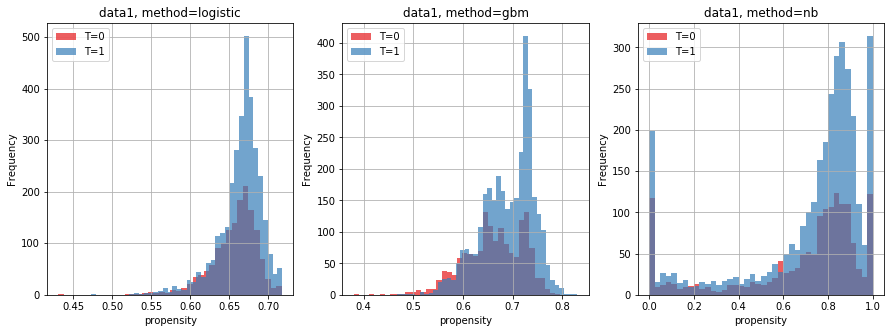

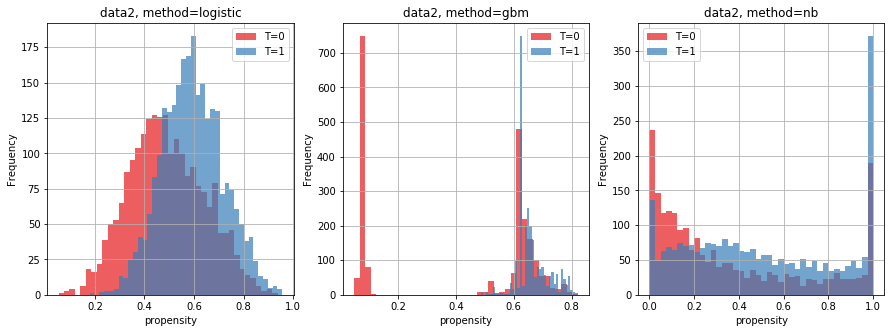

In [10]:
for i, df in enumerate(dataframes):
    fig, ax = plt.subplots(nrows=1, ncols=len(rcv_config.keys()), figsize=(15, 5))
    df_tmp = df.copy()
    for j, method in enumerate(rcv_config.keys()):
        df_tmp['propensity'] = df_propensity[(dataset_names[i], method)]
        groups = df_tmp.groupby('T')
        groups['propensity'].plot(kind='hist', sharex=True, alpha=0.7, bins=40, ax=ax[j])
        ax[j].set_title(f'{dataset_names[i]}, method={method}')
        ax[j].set_xlabel('propensity'); ax[j].grid(True); ax[j].legend([f'T=0','T=1'])

On the first dataset, the logistic and NB methods performed similarly both in terms of Brier score and ROC-AUC, and the GBM method performed slightly better in terms of both metrics.
Based on the results it seems that no method was able to predict $\rvar{T}$ from $\rvec{X}$ very well in the 
first dataset (low ROC-AUC scores), possibly indicating a highly randomized treatment assignment.

On the second dataset the ROC-AUC scores were higher indicating that there is some treatment assignment based on the covariates.
The GBM method was the best performing on this dataset, however it produces sharp propensity distributions with values in a small range.
These results may indicate strong overfitting, and are qualitatively less feasible as distributions obtained
from a real-world selection process.
In addition, the GBM-based approach leads to less common-support in terms of propensity score between the treatment and control groups. This will cause us to ignore more data in order to ensure that the overlap assumption holds.
The logistic method produced more feasible propensity distributions and also achieved ROC-AUC scores almost as as high as GBM with better looking calibration curves. The NB method performed poorly on this dataset.

Based on the results, we opted to use GBM for propensity estimation on the first dataset and Logistic Regression for the second dataset.

In [11]:
# Selected method for propensity estimation per dataset
prop_methods = ('gbm', 'logistic')

df_prop_tmp = pd.DataFrame({
    dataset_names[i]: df_propensity[(dataset_names[i], prop_methods[i])]
    for i in range(len(dataset_names))
})

# Write the propensities to an output file with the requested format.
df_prop_tmp.transpose().to_csv(f'{OUT_DIR}/models_propensity.csv', header=False)
display(df_prop_tmp.transpose())
del df_prop_tmp

,0,1,2,3,4,5,6,7,8,9,...,4792,4793,4794,4795,4796,4797,4798,4799,4800,4801
data1,0.593160,0.575196,0.657778,0.685523,0.651425,0.634825,0.763771,0.706427,0.642891,0.719473,...,0.609872,0.668930,0.678515,0.735086,0.681947,0.650653,0.584677,0.726714,0.580660,0.608582
data2,0.782983,0.588085,0.850419,0.311664,0.443707,0.482647,0.239024,0.755167,0.544056,0.668248,...,0.547398,0.400185,0.363999,0.299447,0.565605,0.381362,0.413389,0.487867,0.606725,0.462564


In order to do causal inference we need the common support ("overlap") assumption to hold:
$$
\forall t,~\vec{x}:\ \Pr\left(\rvar{T}=t\given \rvec{X}=\vec{x}\right)>0.
$$
This means that the the probability of any treatment is possible for any possible covariates of a unit.
In practice we have a limited dataset, and in our specific data this assumption does not hold when
we don't have samples from both groups (treatment and control) within the entire range of propensity scores.
Therefore, to maintain the overlap assumption in our dataset, we'll remove samples for which the propensity
score is outside the range of propensity scores of the other group.
In addition, we'll remove samples with extremely low propensity and high scores as these will cause numerical errors.

The common support calculation is implemented in the `common_support` function within the `propensity.py` module.

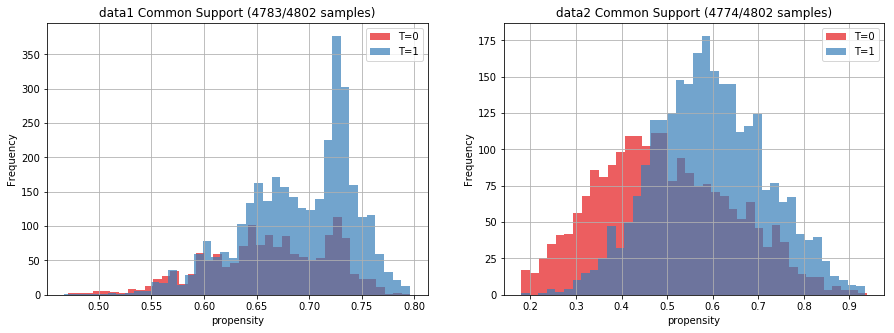

In [12]:
from hw3.propensity import common_support

# We'll save the dataframes after removing samples outside common support
dataframes_cs = []

fig, ax = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(15, 5))
for i, df in enumerate(dataframes):
    df = df.copy()
    df['propensity'] = df_propensity[(dataset_names[i], prop_methods[i])]
    
    # Get common support indices and remove outlying samples
    idx_common = common_support(df['T'].to_numpy(), df['propensity'].to_numpy(),
                                min_thresh=1e-2, max_thresh=1-1e-2)
    df = df[idx_common]
    
    # Save the df with removed samples
    dataframes_cs.append(df)
    
    groups = df.groupby('T')
    groups['propensity'].plot(kind='hist', sharex=True, alpha=0.7, bins=40, ax=ax[i])
    ax[i].set_xlabel('propensity'); ax[i].grid(True); ax[i].legend([f'T=0','T=1'])
    ax[i].set_title(f'{dataset_names[i]} Common Support ({len(df)}/{len(dataframes[i])} samples)')
    
dataframes_cs = tuple(dataframes_cs)

## Part 3: Inverse-Propensity Weighting

The ATT, or average treatment effect on the treated is defined as
$$
\mathrm{ATT} =  \E[]{\rvar{Y}^1-\rvar{Y}^0\given \rvar{T}=1},
$$
where $\rvar{Y}^t$ is the potential outcome of $\rvar{T}=t$ and we assume a binary treatment, i.e. $t\in\setof{0,1}$.

Under the assumption of conditional ignorability, given the covariates $\rvec{X}$,
the potential outcomes are independent of the treatment assignment,
i.e. $(\rvar{Y}^1,\rvar{Y}^0)\indep \rvar{T}\vert \rvec{X}$.
Since we know there are no unmeasured confounders in our data, this assumption holds.
Therefore we can write,
$$
\begin{align}
\mathrm{ATT}
&=  \E[]{\rvar{Y}^1-\rvar{Y}^0\given \rvar{T}=1}\\
&=  \E[\rvec{X}]{\E[]{\rvar{Y}^1-\rvar{Y}^0\given \rvar{T}=1, \rvec{X}}}\\
&=  \E[\rvec{X}]{\E[]{\rvar{Y}^1\given \rvar{T}=1, \rvec{X}}-\E[]{\rvar{Y}^0\given \rvar{T}=1, \rvec{X}}}\\
&=  \E[\rvec{X}]{\E[]{\rvar{Y}^1\given \rvar{T}=1, \rvec{X}}-\E[]{\rvar{Y}^0\given \rvar{T}=0, \rvec{X}}}\\
&=  \E[\rvec{X}]{\E[]{\rvar{Y}\given \rvar{T}=1, \rvec{X}}-\E[]{\rvar{Y}\given \rvar{T}=0, \rvec{X}}}
\end{align}
$$
where we used the conditional ignorability and the consistency assumptions in the second-last and last equations respectively.
This shows the basis for ATT estimation: we can look at the *observed* outcome of a unit from the other group but with the same covariates.

Based on Abdia et al. <cite data-cite="abdia2017">(Abdia, 2017)</cite> we will use our propensity score estimator $\hat e(\rvec{X})$ to estimate the ATT by a sample weighting approach.
Outcome samples from the treated group will get a weight of $1$, while outcomes from the control
group will be given a weight of $\frac{\hat e(\rvec{X})}{1-\hat e(\rvec{X})}$. 
Intuitively, this gives more weight to control-group samples that have low propensity, i.e. ones that
are more "surprisingly" in the control group.

We'll denote the samples in our dataset as $\setof{\left(\vec{x}_i,y_i,t_i\right)}_{i=1}^{N}$.
Thus, the ATT estimator will be,
$$
\widehat{\mathrm{ATT}} =
\frac{\sum_{i=1}^{N} t_i y_i}{\sum_{i=1}^{N} t_i} -
\frac{\sum_{i=1}^{N} (1-t_i)y_i\frac{\hat e(\vec{x}_i)}{1-\hat e(\vec{x}_i)}}
{\sum_{i=1}^{N} (1-t_i)\frac{\hat e(\vec{x}_i)}{1-\hat e(\vec{x}_i)}}.
$$
Note that due to the fact that the treatment variables are binary, $t_i\in\setof{0,1}$,
the first term in the above only sums over the treatment group, with a weight of one per sample,
while the second term only sums over the contol group, with the desired weighting based on the propensity score of the sample.

In [13]:
df_att_results = pd.DataFrame(index=['data1', 'data2'])

In [14]:
import hw3.att as att

df_att_results['ipw'] = float('nan')
for i, df in enumerate(dataframes_cs):
    
    y = df['Y'].to_numpy()
    t = df['T'].to_numpy()
    prop = df['propensity'].to_numpy()
    
    est_att = att.ipw(y, t, prop)
    df_att_results['ipw'][i] = est_att
    
df_att_results[['ipw']]

,ipw
data1,4.733397
data2,3.598257


## Part 4: S-Learner

An S-Learner is a model which predicts the outcome given both the covariates and treatment assignemnt:
$
\hat y = f(\vec{x},t).
$
We will train a supervised regression model and then we can estimate the ATT as
$$
\widehat{\mathrm{ATT}} = \frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}} f(\vec{x}_i, 1)-f(\vec{x}_i,0)
$$
where $\cset{T} := \setof{i \given t_i = 1}$ is the treated group.

We fit four types of models to the data and apply a randomized Cross Validation to select the best parameters for each model and then the best type of model. We test regular linear regression models with L2 regularization (Ridge),
L1 regularization (Lasso), a Gradient Boosting Machine (GBM) and a multilayer perceptron (MLP).

In [15]:
from hw3.cv import CVConfig, MLPHiddenLayerSampler, LogSpaceSampler

# Define model types and parameters samplers for the Cross Validation
import scipy.stats as stats
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

rcv_config = dict(
    ridge=CVConfig(
        model=Ridge(),
        params=dict(alpha=LogSpaceSampler(-3, 1))
    ),
    
    lasso=CVConfig(
        model=Lasso(max_iter=2000,tol=0.001),
        params=dict(alpha=LogSpaceSampler(-3, 1))),
    
    gbm=CVConfig(
        model=GradientBoostingRegressor(),
        params=dict(
            n_estimators=stats.randint(10, 50+1),
            max_depth=stats.randint(1, 3+1),
            learning_rate=LogSpaceSampler(-2, 0.5),
        )),
    
    mlp=CVConfig(
        model=MLPRegressor(solver='lbfgs',),
        params=dict(
            hidden_layer_sizes=MLPHiddenLayerSampler(4, 50),
            activation=['logistic', 'tanh', 'relu'],
            alpha=LogSpaceSampler(-3, 1),
        )),
)

Now we'll fit all four models types to the data and use Cross Validation to find good parameters for each.
The Cross Validation first sets appart 30% of the data as a test test with stratification on $t$.
Then, for each parameter configuration the training set is split further into four folds, again stratified on $t$,
and each time one fold is used as a validation set while the model is fit on the remaining three. We select the best parameters for each model based on average
$R^2$ score on the validation sets for that parameter configuration.

This procedure is implemented by the `fit_slearner_cv` function in the `cv.py` module.

In [16]:
from hw3.att import fit_slearner_cv

# Create a dataframe to store the CV results
df_cv_slearner = pd.DataFrame(
    index=pd.MultiIndex.from_product([dataset_names, rcv_config.keys()]),
    columns=('train', 'test', 'cv_model')
)

# Run each CV configuration
for i, df in enumerate(dataframes_cs):
    X, y, t, _ = get_training_data(df)
    
    for model_name, cv_cfg in rcv_config.items():
        
        model, train_score, test_score = fit_slearner_cv(
            cv_cfg, X, y, t, random_state=42042+i,
            interaction=True, test_size=0.3, cv_splits=4, n_iter=16
        )
    
        df_cv_slearner.loc[(dataset_names[i], model_name), :] = [train_score, test_score, model]
        print(f'{dataset_names[i]}\tmodel={model_name}\tbest_params={model.best_params_}')

df_cv_slearner[['train', 'test']]

data1	model=ridge	best_params={'model__alpha': 7.136153179865257}
data1	model=lasso	best_params={'model__alpha': 0.017215187409600003}
data1	model=gbm	best_params={'model__learning_rate': 0.16681568872953634, 'model__max_depth': 3, 'model__n_estimators': 46}
data1	model=mlp	best_params={'model__activation': 'relu', 'model__alpha': 9.695997255303146, 'model__hidden_layer_sizes': (16, 42, 44)}
data2	model=ridge	best_params={'model__alpha': 0.0012161514434975954}
data2	model=lasso	best_params={'model__alpha': 0.024459893113623794}
data2	model=gbm	best_params={'model__learning_rate': 0.28011956494445395, 'model__max_depth': 3, 'model__n_estimators': 31}
data2	model=mlp	best_params={'model__activation': 'relu', 'model__alpha': 0.466316621985628, 'model__hidden_layer_sizes': (42, 47, 33)}


train      test
data1 ridge  0.571596  0.562413
      lasso  0.565828  0.564966
      gbm    0.945455  0.930258
      mlp     0.96376  0.927959
data2 ridge  0.408591  0.345509
      lasso  0.393334  0.344651
      gbm      0.9607  0.949812
      mlp    0.975383  0.922303

The table above shows the $R^2$ score of the different models on the train set (70% of the data) and test set (30%).
We can see that the non-linear models (GBM and MLP) produce much better results than the linear models (Ridge and Lasso),
with relatively minimal overfitting. We will select the best S-Learner model for each dataset based on the test-set score.

We now use the best model to estimate the ATT in each dataset.
In addition, we use the previously-calculated propensity scores $\hat e(\vec{x})$ to obtain a doubly-robust (DR) estimator,
in the following way:

$$
\begin{align}
\widehat{\mathrm{ATT}}_{DR}
&= 
\frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}}
\left[
    \frac{t_i y_i}{\hat e(\vec{x}_i)} - \frac{t_i - \hat e(\vec{x}_i)}{\hat e(\vec{x}_i)}\cdot f(\vec{x}_i, 1)
\right]
-
\frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}}
\left[
    \frac{(1-t_i)y_i}{1-\hat e(\vec{x}_i)} + \frac{t_i-\hat e(\vec{x}_i)}{1-\hat e(\vec{x}_i)}\cdot f(\vec{x}_i, 0)
\right] \\
&=
\frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}}
\left[
    f(\vec{x}_i, 1) - \frac{t_i}{\hat e(\vec{x}_i)} \cdot \left( f(\vec{x}_i, 1) - y_i\right)
\right]
-
\frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}}
\left[
    f(\vec{x}_i, 0) - \frac{1-t_i}{1-\hat e(\vec{x}_i)} \cdot \left( f(\vec{x}_i, 0) - y_i\right)
\right].
\end{align}
$$

Note that since we're only looking at the treated group $\cset{T}$, the second term in the second sum is zero.
This method takes the estimation error $\hat{y}_i - y_i$ into account and weights it according to the inverse
propensity. It was shown to produce unbiased estimations of the treatment effect even if only one of the models (propensity or outcome regressor) is unbiased.

The S-Learner ATT estimation based on the best model is implemented in the `s_learner` function within the `att.py` module.

In [17]:
# Estimate ATT with S-Learner, using best fitted model for each dataset.
df_att_results['s_learner'] = float('nan')

for i, df in enumerate(dataframes_cs):
    # Get data
    X, y, t, p = get_training_data(df)
    
    # Get best model based on test-set score on the current dataset
    model_name = df_cv_slearner.loc[dataset_names[i], 'test'].astype(float).idxmax() 
    model = df_cv_slearner.loc[(dataset_names[i], model_name), 'cv_model']
    print(f'{dataset_names[i]}: estimating with {model_name}{model.best_params_}')
    
    est_att = att.s_learner(model, X, y, t, propensity=p, interaction=True)
    df_att_results['s_learner'][i] = est_att
    
df_att_results

data1: estimating with gbm{'model__learning_rate': 0.16681568872953634, 'model__max_depth': 3, 'model__n_estimators': 46}
data2: estimating with gbm{'model__learning_rate': 0.28011956494445395, 'model__max_depth': 3, 'model__n_estimators': 31}


,ipw,s_learner
data1,4.733397,4.615843
data2,3.598257,2.380761


## Part 4: T-Learner

The T-Learner formulation consists of fitting two different model which predict the outcome $\rvar{Y}$ given the covariates $\rvec{X}$ alone. The first model,  
$
\hat y_1 = f_1(\vec{x})
$
, is fitted on the treated group
and the second model,
$
\hat y_0 = f_0(\vec{x})
$
, is fitted on the control group.

Then we can estimate the ATT as
$$
\widehat{\mathrm{ATT}} = \frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}} f_1(\vec{x}_i)-f_0(\vec{x}_i).
$$
In other words, these models are used for estimating the counterfactual outcome when used for inference
on a data point belonging the group they weren't fitted on.

We'll fit the same types of models using the same CV scheme as for the S-Learner, but now we'll split each dataset into the treatment and control groups before fitting.
This will give us a best estimator per dataset and per group.

In [18]:
group_names = ('Treated', 'Control')

# Create a dataframe to store the CV results
df_cv_tlearner = pd.DataFrame(
    index=pd.MultiIndex.from_product([dataset_names, rcv_config.keys()]),
    columns=pd.MultiIndex.from_product([group_names, ('train', 'test', 'cv_model')])
)

In [19]:
# Run each CV configuration
for i, df in enumerate(dataframes_cs):
    X, y, t, _ = get_training_data(df)
    idx_treat = t == 1
    
    for model_name, cv_cfg in rcv_config.items():
        
        # Apply CV-based fitting in each group
        for k, idx in enumerate((idx_treat, ~idx_treat)):
            common_args = dict(random_state=42042+i+k, interaction=None, test_size=0.3,
                               cv_splits=3, n_iter=42)
            
            model, train_score, test_score = fit_slearner_cv(
                cv_cfg, X[idx], y[idx], t[idx], **common_args
            )
            
            df_cv_tlearner.loc[(dataset_names[i], model_name), group_names[k]] = [
                train_score, test_score, model
            ]
        
            print(f'{dataset_names[i]}-{group_names[k]}\tmodel={model_name}\tbest_params={model.best_params_}')

df_cv_tlearner.loc[:, pd.IndexSlice[:, ('train', 'test')]]

data1-Treated	model=ridge	best_params={'model__alpha': 9.695997255303146}
data1-Control	model=ridge	best_params={'model__alpha': 9.89505398323565}
data1-Treated	model=lasso	best_params={'model__alpha': 0.052343209114349344}
data1-Control	model=lasso	best_params={'model__alpha': 0.033385055114052924}
data1-Treated	model=gbm	best_params={'model__learning_rate': 0.18922765860438318, 'model__max_depth': 3, 'model__n_estimators': 49}
data1-Control	model=gbm	best_params={'model__learning_rate': 0.296268448430213, 'model__max_depth': 2, 'model__n_estimators': 45}
data1-Treated	model=mlp	best_params={'model__activation': 'tanh', 'model__alpha': 0.01428990820943894, 'model__hidden_layer_sizes': (4, 50)}
data1-Control	model=mlp	best_params={'model__activation': 'logistic', 'model__alpha': 9.89505398323565, 'model__hidden_layer_sizes': (26,)}
data2-Treated	model=ridge	best_params={'model__alpha': 9.89505398323565}
data2-Control	model=ridge	best_params={'model__alpha': 8.964330858424626}
data2-Tre

Treated             Control          
                train      test     train      test
data1 ridge  0.406122  0.354334  0.706333  0.710004
      lasso  0.399361  0.362423  0.703066  0.717551
      gbm    0.966118  0.960123  0.949131  0.923885
      mlp    0.962708   0.95172  0.965895  0.838298
data2 ridge   0.26345  0.221716  0.505951  0.444844
      lasso  0.226745  0.212872  0.483502  0.441075
      gbm    0.976419  0.953138  0.924748   0.89875
      mlp    0.978383  0.916965  0.959034  0.824295

The table above shows the $R^2$ score of the different models on the train set (70% of the data) and test set (30%).
As before, the non-linear models produce much better results than the linear models,
and specifically the GBM seems to perform best in all cases.
We will select the best model separately for each group and dataset based on the test-set score, so in total we'll have four best-fitted regression models.

We now use the best models to estimate the ATT in each dataset.
We'll again use the propensity scores $\hat e(\vec{x})$ to obtain a doubly-robust (DR) estimator,
but this time it uses a different model in each group:

$$
\widehat{\mathrm{ATT}}_{DR} = 
\frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}}
\left[
    \frac{t_i y_i}{\hat e(\vec{x}_i)} - \frac{t_i - \hat e(\vec{x}_i)}{\hat e(\vec{x}_i)}\cdot f_1(\vec{x}_i)
\right]
-
\frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}}
\left[
    \frac{(1-t_i)y_i}{1-\hat e(\vec{x}_i)} + \frac{t_i-\hat e(\vec{x}_i)}{1-\hat e(\vec{x}_i)}\cdot f_0(\vec{x}_i)
\right].
$$

The T-Learner ATT estimation based on the best models is implemented in the `t_learner` function within the `att.py` module.

In [20]:
# Estimate ATT with T-Learner, using best fitted model for each dataset and group.
df_att_results['t_learner'] = float('nan')

for i, df in enumerate(dataframes_cs):
    # Get data
    X, y, t, p = get_training_data(df)
    
    # Loop over treatment/control groups and get the best model
    best_models = {}
    for group_name in group_names:
        
        # Get index of best model based on test-set score on the current dataset and group
        imax = df_cv_tlearner.loc[pd.IndexSlice[dataset_names[i],:],
                                  pd.IndexSlice[group_name, 'test']].astype(float).idxmax()
        
        # Save best model for this group
        model_name = imax[-1]
        model = df_cv_tlearner.loc[imax,(group_name, 'cv_model')]
        best_models[group_name] = model
        
        print(f'{dataset_names[i]}-{group_name}: estimating with {model_name}{model.best_params_}')

    # Estimate the ATT using the two best models for this dataset
    est_att = att.t_learner(
        best_models[group_names[0]], best_models[group_names[1]],
        X, y, t, propensity=p
    )
    df_att_results['t_learner'][i] = est_att
    
df_att_results

data1-Treated: estimating with gbm{'model__learning_rate': 0.18922765860438318, 'model__max_depth': 3, 'model__n_estimators': 49}
data1-Control: estimating with gbm{'model__learning_rate': 0.296268448430213, 'model__max_depth': 2, 'model__n_estimators': 45}
data2-Treated: estimating with gbm{'model__learning_rate': 0.28011956494445395, 'model__max_depth': 3, 'model__n_estimators': 31}
data2-Control: estimating with gbm{'model__learning_rate': 0.4592532415205829, 'model__max_depth': 2, 'model__n_estimators': 40}


,ipw,s_learner,t_learner
data1,4.733397,4.615843,4.281646
data2,3.598257,2.380761,2.591186


## Part 5: Matching

In the context of causal inference "matching" refers to estimating the causal effect of treatment on outcome by finding
the "counterfactual twin" of each sample: a sample from the opposite treatment group which has covariates as similar as
possible, under some given similarity metric.

Here we implement 1-NN (nearest neighbor) matching, which can be written formally as
$$
\widehat{\mathrm{ATT}} = \frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}} y_i - y_{j(i)},
$$
where $j(i)$ is the index of the nearest counterfactual neighbor, i.e.
$$
j(i)=\arg\min_{j\notin\cset{T}} d(x_i, x_j)
$$
and $d(\cdot,\cdot)$ is some distance metric over the covariates.
In the case of propensity-score matching (PSM) the distance metric is performed over the propensity scores
instead of the covariates.

The purpose of matching is to estimate the ATT from a **balanced** dataset.
In this context, balance means the the covariates of the treated and control group have similar marginal
distributions. Intuitively, makes the dataset more similar to an RCT since if indeed all covariates
are identically distributed between the treatment and control groups then the treatment assignment is effectively random.

We'll try multiple matching configurations:
- Covariate matching using euclidean (l2), cosine and Mahalanobis distance metrics.
- Propensity score matching (the distance metric will simply be the difference).
- Random matching, where each treatment sample is matched with a random control sample.

To assess which method is preferred, we'll estimate the level of balance after matching by comparing the
covariate distributions using two methods:
- Wasserstein distance, also known as earth-mover's distance. Quantifies the distance between two distributions by measuring how much one must change to transform into the other.
- Standardized mean-difference (SSMD) distance, a statistical metric which we'll define as
  $$
  \mathrm{SSMD}(\rvar{x},\rvar{y})=\left|\frac{\E[]{\rvar{x}-\rvar{y}}}{\Var{\rvar{x}-\rvar{y}}}\right|.
  $$
  
After matching, we measure these metrics on the covariates of the matches pairs,
and compare the matched treated group to the matched control group.
To obtain balanced data after matching, we would like these metrics to be small.

First, we'll measure the level of balance between the treatment and control groups in the unmatched data using both metrics.

In [66]:
balance_metrics = ['wass', 'ssmd']
df_balance = pd.DataFrame(columns=pd.MultiIndex.from_product([dataset_names, balance_metrics]))

for i, df in enumerate(dataframes_cs):
    X, y, t, p = get_training_data(df, scale_covariates=True)
    X_treat, X_ctrl = X[t == 1], X[t == 0]
    
    df_balance[(dataset_names[i], 'wass')] = wass_dist(X_treat, X_ctrl)
    df_balance[(dataset_names[i], 'ssmd')] = ssmd_dist(X_treat, X_ctrl)
    
df_balance.describe()

data1                 data2              
            wass       ssmd       wass          ssmd
count  58.000000  58.000000  58.000000  5.800000e+01
mean    0.041448   0.075383   0.066991  5.046344e-02
std     0.034585   0.069008   0.097261  6.706986e-02
min     0.001525   0.000000   0.003109  1.331176e-18
25%     0.026553   0.024043   0.023005  1.696426e-02
50%     0.037581   0.056413   0.031931  2.525836e-02
75%     0.043115   0.118934   0.054542  5.206848e-02
max     0.234109   0.330292   0.456489  3.333622e-01

Now we'll match every treatment-group sample to it's closest counterfactual counterpart in the control group.
We'll discard matches that are further by some tolerance `tol` relative to the average distance of all samples.

The code implementing the matching algorithm and the distance metrics can be found in the `matching.py` module.

In [68]:
from hw3.matching import covariate_matching, propensity_matching, ssmd_dist, wass_dist
import hw3.att as att

# Distance tolerance is relative to average distance per metric
tol = 1.25 
matching_methods = {'random', 'cosine', 'euclidean', 'mahalanobis', 'propensity'}

# DataFrame for matching results
df_matching = pd.DataFrame(columns=pd.MultiIndex.from_product([dataset_names, matching_methods]))

for i, df in enumerate(dataframes_cs):
    # Get data
    X, y, t, p = get_training_data(df, scale_covariates=True)
    X_treat = X[t == 1]

    for method in matching_methods:
        if method == 'propensity':
            X_ctrl_m, X_treat_m, idx_ctrl_m, idx_treat_m, dists = propensity_matching(X, t, p, tol=tol)
            
        else:
            X_ctrl_m, X_treat_m, idx_ctrl_m, idx_treat_m, dists = covariate_matching(X, t, method, tol=tol)
        
        print(f'Matching {dataset_names[i]} method={method} {len(X_treat_m)}/{len(X_treat)}')
        
        # Metrics
        mean_dist = np.mean(dists)
        pct_matched = int(len(X_treat_m)/len(X_treat)*100)
        mean_wass = np.mean(wass_dist(X_treat_m, X_ctrl_m))
        mean_ssmd = np.mean(ssmd_dist(X_treat_m, X_ctrl_m))
        est_att = att.matching(y, idx_treat_m, idx_ctrl_m)
        df_matching[(dataset_names[i], method)] = [mean_dist, pct_matched, mean_wass, mean_ssmd, est_att]
        
df_matching.index = ['mean_dist', '% matched', 'mean_wass','mean_ssmd', 'est_att']
df_matching = df_matching.transpose()
df_matching

Matching data1 method=cosine 2799/3261
Matching data1 method=mahalanobis 2742/3261
Matching data1 method=random 3261/3261
Matching data1 method=propensity 2752/3261
Matching data1 method=euclidean 2716/3261
Matching data2 method=cosine 2257/2622
Matching data2 method=mahalanobis 2179/2622
Matching data2 method=random 2622/2622
Matching data2 method=propensity 2149/2622
Matching data2 method=euclidean 2158/2622


mean_dist  % matched  mean_wass  mean_ssmd   est_att
data1 cosine        0.331253       85.0   0.042679   0.029904  4.892722
      mahalanobis   5.653748       84.0   0.097749   0.106226  3.547916
      random       10.356627      100.0   0.049784   0.027859  5.445111
      propensity    0.000034       84.0   0.050550   0.026143  4.154217
      euclidean     5.041099       83.0   0.080724   0.084638  3.815009
data2 cosine        0.322059       86.0   0.056917   0.043987  3.680945
      mahalanobis   5.584988       83.0   0.101717   0.113827  3.703583
      random       10.339101      100.0   0.071431   0.044761  3.956178
      propensity    0.000091       81.0   0.046518   0.021976  3.536241
      euclidean     4.982998       82.0   0.087022   0.099410  3.721929

The results show that generally propensity-score and cosine-distance matching work best for these datasets,
in terms of the balance achieved after matching. These methods always improved the balance score
(compared to the score for the unmatched data) as measured with both metrics.

Note also that for the first dataset, we also see that the random matching achieves relatively good balance;
this implies that the original groups in the dataset are fairly balanced to begin with and further matching does
not help much. This makes sense given the very similar propensity score distributions we saw in part 2 on this dataset.

We'll choose the estimate the ATT using the best matching method in terms of Wasserstein distance.

In [69]:
metric = 'mean_wass'
df_att_results['matching'] = float('nan')

for i, dataset_name in enumerate(dataset_names):
    imax = df_matching.loc[pd.IndexSlice[dataset_name, :], metric].idxmin()
    print(f'{imax[0]}: best_method={imax[1]}')
    
    df_att_results['matching'][i] = df_matching.loc[imax, 'est_att']

df_att_results

data1: best_method=cosine
data2: best_method=propensity


,ipw,s_learner,t_learner,matching
data1,4.733397,4.615843,4.281646,4.892722
data2,3.598257,2.380761,2.591186,3.536241
